# Phase 3 Project
**Client:** Providence (Most medical centers) <br>
**Authors:** Tommy Phung

## Overview
According to the [CDC](https://www.cdc.gov/flu/prevent/vaxsupply.htm#:~:text=Flu%20vaccine%20is%20produced%20by,for%20the%202022%2D2023%20season.), there is a projected supply of over 170 million influenza vaccines throughout the United States. Many hospitals do not keep track of the number of vaccines they waste. History shows that vaccines are unused as well. <br>
**An estimated 71 million H1N1 flu vaccines were unused, and an estimated 1.1 billion Covid Vaccines went to waste due to expired vaccines and supply chain issues.** <br>

With the growing doubts about vaccine effectiveness, patients have been questioning whether to take the Covid-19 vaccine. We used the National 2009 H1N1 Flu Survey provided by [United States National Center for Health Statistics](https://www.cdc.gov/nchs/index.htm) for our dataset. We will be modeling to see if we can predict whether an individual has taken the Seasonal Vaccine based on several different features from their responses in the survey. Using the model, a medical center can have a rough idea of the number of vaccines needed. 

Three models were created using decision trees and random forest algorithms. <br>
**The Decision tree** was used as a baseline model in order to find improvements. Little to no changes were made to the parameters. <br>
**The Random Forest** was the solution to the decision tree's initial problems. The model was an improvement to the baseline but could be better if tuned for the best accuracy. <br>
Lastly, the **Tuned Random Forest** to find the best combinations of parameters for the model. Multiple combination were look through using **Gridsearch.**  <br> 
The model progressively improves the training and testing accuracy in order to predict the patient's vaccine status. 

## Import Libraries
Majority of the libraries being used are from sklearn in order to format the data and create the regression models.

In [1]:
import pandas as pd    # Read the dataset into a dataframe and general adjustments to data points
import numpy as np    

## Ploting Libraries ##
import matplotlib.pyplot as plt 
from sklearn import tree

## Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score    # Split dataset to training sets, Perform multiple iteractions and perform cross value scores
from sklearn.preprocessing import MinMaxScaler     # Scalers to scale the dataset 
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Classifiers ##
from sklearn.tree import DecisionTreeClassifier    # The basic regression model using Decision tree
from sklearn.ensemble import RandomForestClassifier    # A more complex model with Random Forests
from xgboost import XGBClassifier

## Import Dataset
The dataset was seperated into training dataset and testing dataset. The data only had the target results from the 'testing' set so we will only be using that for our modeling. <br>
We will be focusing mainly on the **Seasonal Vaccine**. 

In [2]:
features = pd.read_csv('Data/training_set_features.csv')    # Original Dataset
labels = pd.read_csv('Data/training_set_labels.csv')    # Original Dataset
target = labels['seasonal_vaccine'].copy()    # Only the seasonal vaccine column

## Business Understanding 
Vaccines are a useful way to prevent viral infections. One of the most common viral infections is influenza or most commonly known as the flu. The CDC recommends individuals receive the vaccine during the flu season every year. However, since vaccines aren't mandatory, individuals can deny them through personal beliefs or limited knowledge of the vaccine. When vaccines go unused, they are wasted in the center rather than distributed to centers needed. <br> 

**The vaccines could have been distributed to areas with inadequate number of vaccines.**

**For example, 1.1 billion Covid Vaccines were estimated to be wasted due to expired vaccines and supply chain issues.** <br>

To give patients the vaccines as efficiently as possible, hospitals and medical centers store vaccines. With the dataset, we could predict whether a patient would want a vaccine based on their answers to the survey. Medical centers can then order an adequate amount of vaccines with little waste. 

## Data Exploration
1. Number of obversations
2. Check for duplicates, NaN's and Missing values
3. Check columns data type 

In [3]:
## 1. 26,707 observations
print(f'There are {len(features)} in the dataset')

## 2. Check for duplicates
df_list = [features, labels]
if sum([dataframe.duplicated().sum() for dataframe in df_list]) > 0:
    print('Dataframes have duplicates')
else:
    print('No duplicates found')

## Check for NaN / Missing Values
if sum([dataframe.isna().sum().values.sum() for dataframe in df_list]) > 0:
    print('Dataframes have missing values')
else:
    print('Dataframes have no missing values')

## 3. Check columns data types
for dtype in [object, 'number']:
    print('There are {} columns with the data type, {} data types that need to be converted. '.format(sum([len(features.select_dtypes(dtype).columns)]), dtype))

There are 26707 in the dataset
No duplicates found
Dataframes have missing values
There are 12 columns with the data type, <class 'object'> data types that need to be converted. 
There are 24 columns with the data type, number data types that need to be converted. 


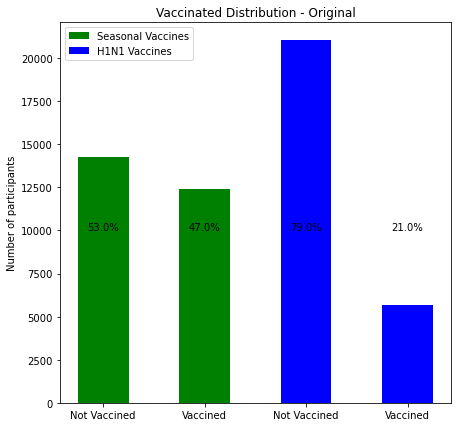

In [4]:
def add_labels(x, y):
    for index in x:
        plt.text(index, 10000, y[index], ha = 'center')
        
values = list(labels['seasonal_vaccine'].value_counts().values) + list(labels['h1n1_vaccine'].value_counts().values)
fig, ax = plt.subplots(figsize= (7, 7))
plt.xticks(np.arange(4), ['Not Vaccined', 'Vaccined', 'Not Vaccined', 'Vaccined'])
plt.bar([0,1], height= list(labels['seasonal_vaccine'].value_counts().values) , width= .5, color = 'green', label = 'Seasonal Vaccines');
plt.bar([2,3], height= list(labels['h1n1_vaccine'].value_counts().values) , width= .5, color = 'blue', label = 'H1N1 Vaccines');
ax.set_title('Vaccinated Distribution - Original');
ax.set_ylabel('Number of participants')
ax.legend();
value_list = ['{}%'.format(round(item, 2)*100) for item in (list(labels['seasonal_vaccine'].value_counts(normalize= True).values) + list(labels['h1n1_vaccine'].value_counts(normalize= True).values))]

add_labels(np.arange(4), value_list)

After looking through the dataset, we can see that their is a **roughly 50%** spread in whether a patients take the seasonal vaccine. Rather than guessing, we can create a model in order to make a better prediction than 50%. 

## Data Understanding
The dataset consists of binary and numerical entries based on their answers to a survey. To model the dataset, all of the data types need to be numeric so dummy variables are needed for 12 of the columns. After the dummy variables were made, there are over 100 different columns created and will be used in the modeling. We looked at **accuracy** and **recall** scores to see how well the model performs and if a higher recall score can lead to a better resulting model. The accuracy score is used to gauge how well the model performs. The recall score will be used to give certainty that the patient who needs the vaccines will receive one. 

The following is a graph with all the features from the survey as well as a description of the label. 

***<p style="text-align: center;">Features</p>***


| Label                       | Description                                                                                                                                                                                                                                                                                                                                     |
|:-----------------------------|------------------------------------------------------------------------------------------------:|
| h1n1_concern                | Level of concern about the H1N1 flu|
| h1n1_knowledge              | Level of knowledge about H1N1 flu|
| behavioral_antiviral_meds   | Has taken antiviral medications|
| behavioral_avoidance        | Has avoided close contact with others with flu-like symptoms|
| behavioral_face_mask        | Has bought a face mask|
| behavioral_wash_hands       | Has frequently washed hands or used hand sanitizer|
| behavioral_large_gatherings | Has reduced time at large gatherings|
| behavioral_outside_home     | Has reduced contact with people outside of own household|
| behavioral_touch_face       | Has avoided touching eyes, nose, or mouth|
| doctor_recc_h1n1            | H1N1 flu vaccine was recommended by doctor|
| doctor_recc_seasonal        | Seasonal flu vaccine was recommended by doctor|
| chronic_med_condition       | Has a chronic medical condition|
| child_under_6_months        | Has regular close contact with a child under the age of six months|
| health_worker               | Is a healthcare worker|
| health_insurance            | Has health insurance|
| opinion_h1n1_vacc_effective | Respondent's opinion about H1N1 vaccine effectiveness|
| opinion_h1n1_risk           | Respondent's opinion about the risk of getting sick with H1N1 flu without vaccine|
| opinion_h1n1_sick_from_vacc | Respondent's worry about getting sick from taking the H1N1 vaccine|
| opinion_seas_vacc_effective | Respondent's opinion about seasonal flu vaccine effectiveness|
| opinion_seas_risk           | Respondent's opinion about the risk of getting sick with seasonal flu without vaccine|
| opinion_seas_sick_from_vacc | Respondent's worry of getting sick from taking seasonal flu vaccine|
| age_group                   | Age group of respondent|
| education                   | Self-reported education level|
| race                        | Race of respondent|
| sex                         | Sex of respondent|
| income_poverty              | Household annual income of respondent to 2008 Census poverty thresholds|
| marital_status              | Marital status of respondent|
| rent_or_own                 | Housing situation of the respondent.|
| employment_status           | Employment status of the respondent.|
| hhs_geo_region              | Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services.|
| census_msa                  | Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census |
| household_adults            | Number of other adults in the household, top-coded to 3|
| household_children          | Number of children in household, top-coded to 3|
| employment_industry         | Type of industry respondent is employed in. Values are represented as short random character strings|
| employment_occupation       | Type of occupation of the respondent. Values are represented as short random character strings|


***<p style="text-align: center;">Targets</p>***

| Label            | Description                                      |
|------------------|--------------------------------------------------:|
| h1n1_vaccine     | Whether respondent received H1N1 flu vaccine     |
| seasonal_vaccine | Whether respondent received seasonal flu vaccine |

For this model, we will be focusing on the **season flu vaccine** label from the dataset.

## Data Preperation
1. The dataframe are to be split into training set and testing set using 80/20 split.
2. Find all the weight for each value of each columns to randomly choose.
3. Fill all the missing values with the random value
4. The categorical data have dummy variables made for regression model
5. Normalize the data to have the same scale

In [5]:
## 1. Split the dataframe 
X_train, X_test, y_train, y_test = train_test_split(features.drop('respondent_id', axis = 1), target, test_size= .20, random_state= 420, stratify=target)

In [31]:
## 1a. Check the spread of the classes

print(y_train.value_counts(normalize = True))
y_test.value_counts(normalize= True)

0    0.534379
1    0.465621
Name: seasonal_vaccine, dtype: float64


0    0.534444
1    0.465556
Name: seasonal_vaccine, dtype: float64

In [6]:
## 2. Calulate the weight of the values
# For reproductivity
np.random.seed(420)  

for dataset in [X_train, X_test]:
    missing_labels = {}
    # Determing the probability of a given value in a given column
    for column in dataset.columns:
        if dataset[column].isna().sum() > 0:
            counts = dataset[column].value_counts(normalize= True)
            missing_labels[column] = [counts.keys(), counts.values]
        ## 3. Fill all the missing values
    # For each of the missing columns, give the missing value a random value
    for column in missing_labels:
        indexs = dataset[column].loc[dataset[column].isna() == True].index
        values = np.random.choice(missing_labels[column][0], p = missing_labels[column][1], size = len(indexs))
        na_map = dict(zip(indexs, values))
        dataset[column].fillna(na_map, inplace= True)

In [7]:
## 4.  Create dummy variables
X_train_scaled = pd.get_dummies(X_train, columns= X_train.select_dtypes(object).columns)
X_test_scaled = pd.get_dummies(X_test, columns= X_train.select_dtypes(object).columns)

In [8]:
## 5. Fit and transform the dataset with the dataset
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns= X_train_scaled.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled), columns= X_test_scaled.columns)

In [9]:
print('{} total columns'.format(len(X_train_scaled.columns)))

105 total columns


## Pipeline Version
Pipeline was used to help simplify the preprocessing steps for the training and testing set. Classifiers are added since three two different classifiers were used. 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [11]:
transformer = ColumnTransformer(transformers= [('ohe', OneHotEncoder(categories= 'auto', handle_unknown= 'ignore', sparse_output= False), X_train.select_dtypes(object).columns)],                 
                                remainder = 'drop')
pipeline = Pipeline(steps= 
                    [('col_transformer', transformer),
                     ('scaler', MinMaxScaler())])

transformed_X_train = pipeline.fit_transform(X_train)
encoder = transformer.named_transformers_['ohe']
category_labels = [element for i in list(range(len(encoder.categories_))) for element in encoder.categories_[i]]


transformed_X_test = pipeline.transform(X_test)

X_train_piped = pd.DataFrame(transformed_X_train, columns=category_labels, index = X_train.index)
X_train_2 = pd.concat([X_train[X_train.select_dtypes('number').columns], X_train_piped], axis= 1)
X_test_piped = pd.DataFrame(transformed_X_test, columns=category_labels, index = X_test.index)
X_test_2 = pd.concat([X_test[X_test.select_dtypes('number').columns],X_test_piped], axis= 1)

## Modeling

### Baseline Regression Model - Decision Tree

The baseline regression model I used was a Decision Tree. Majority of the parameters wasn't changed and a random state was set to allow reproductivity. Decision Tree can be used for classification and regression problems so this was a good start to see how the model perform. 

In [12]:
## Decision Tree with default parameters other than the criterion ##
tree_clf = DecisionTreeClassifier(criterion= 'entropy', random_state= 420)
tree_model = tree_clf.fit(X_train_scaled,y_train)

## Add into a list for the scores found from the classifer ## 
tree_scores = []
tree_scores.append(tree_clf.score(X_train_scaled, y_train))
tree_scores.append(tree_clf.score(X_test_scaled, y_test))
tree_scores.append(cross_val_score(tree_clf, X_test_scaled, y_test, scoring= 'accuracy').mean())

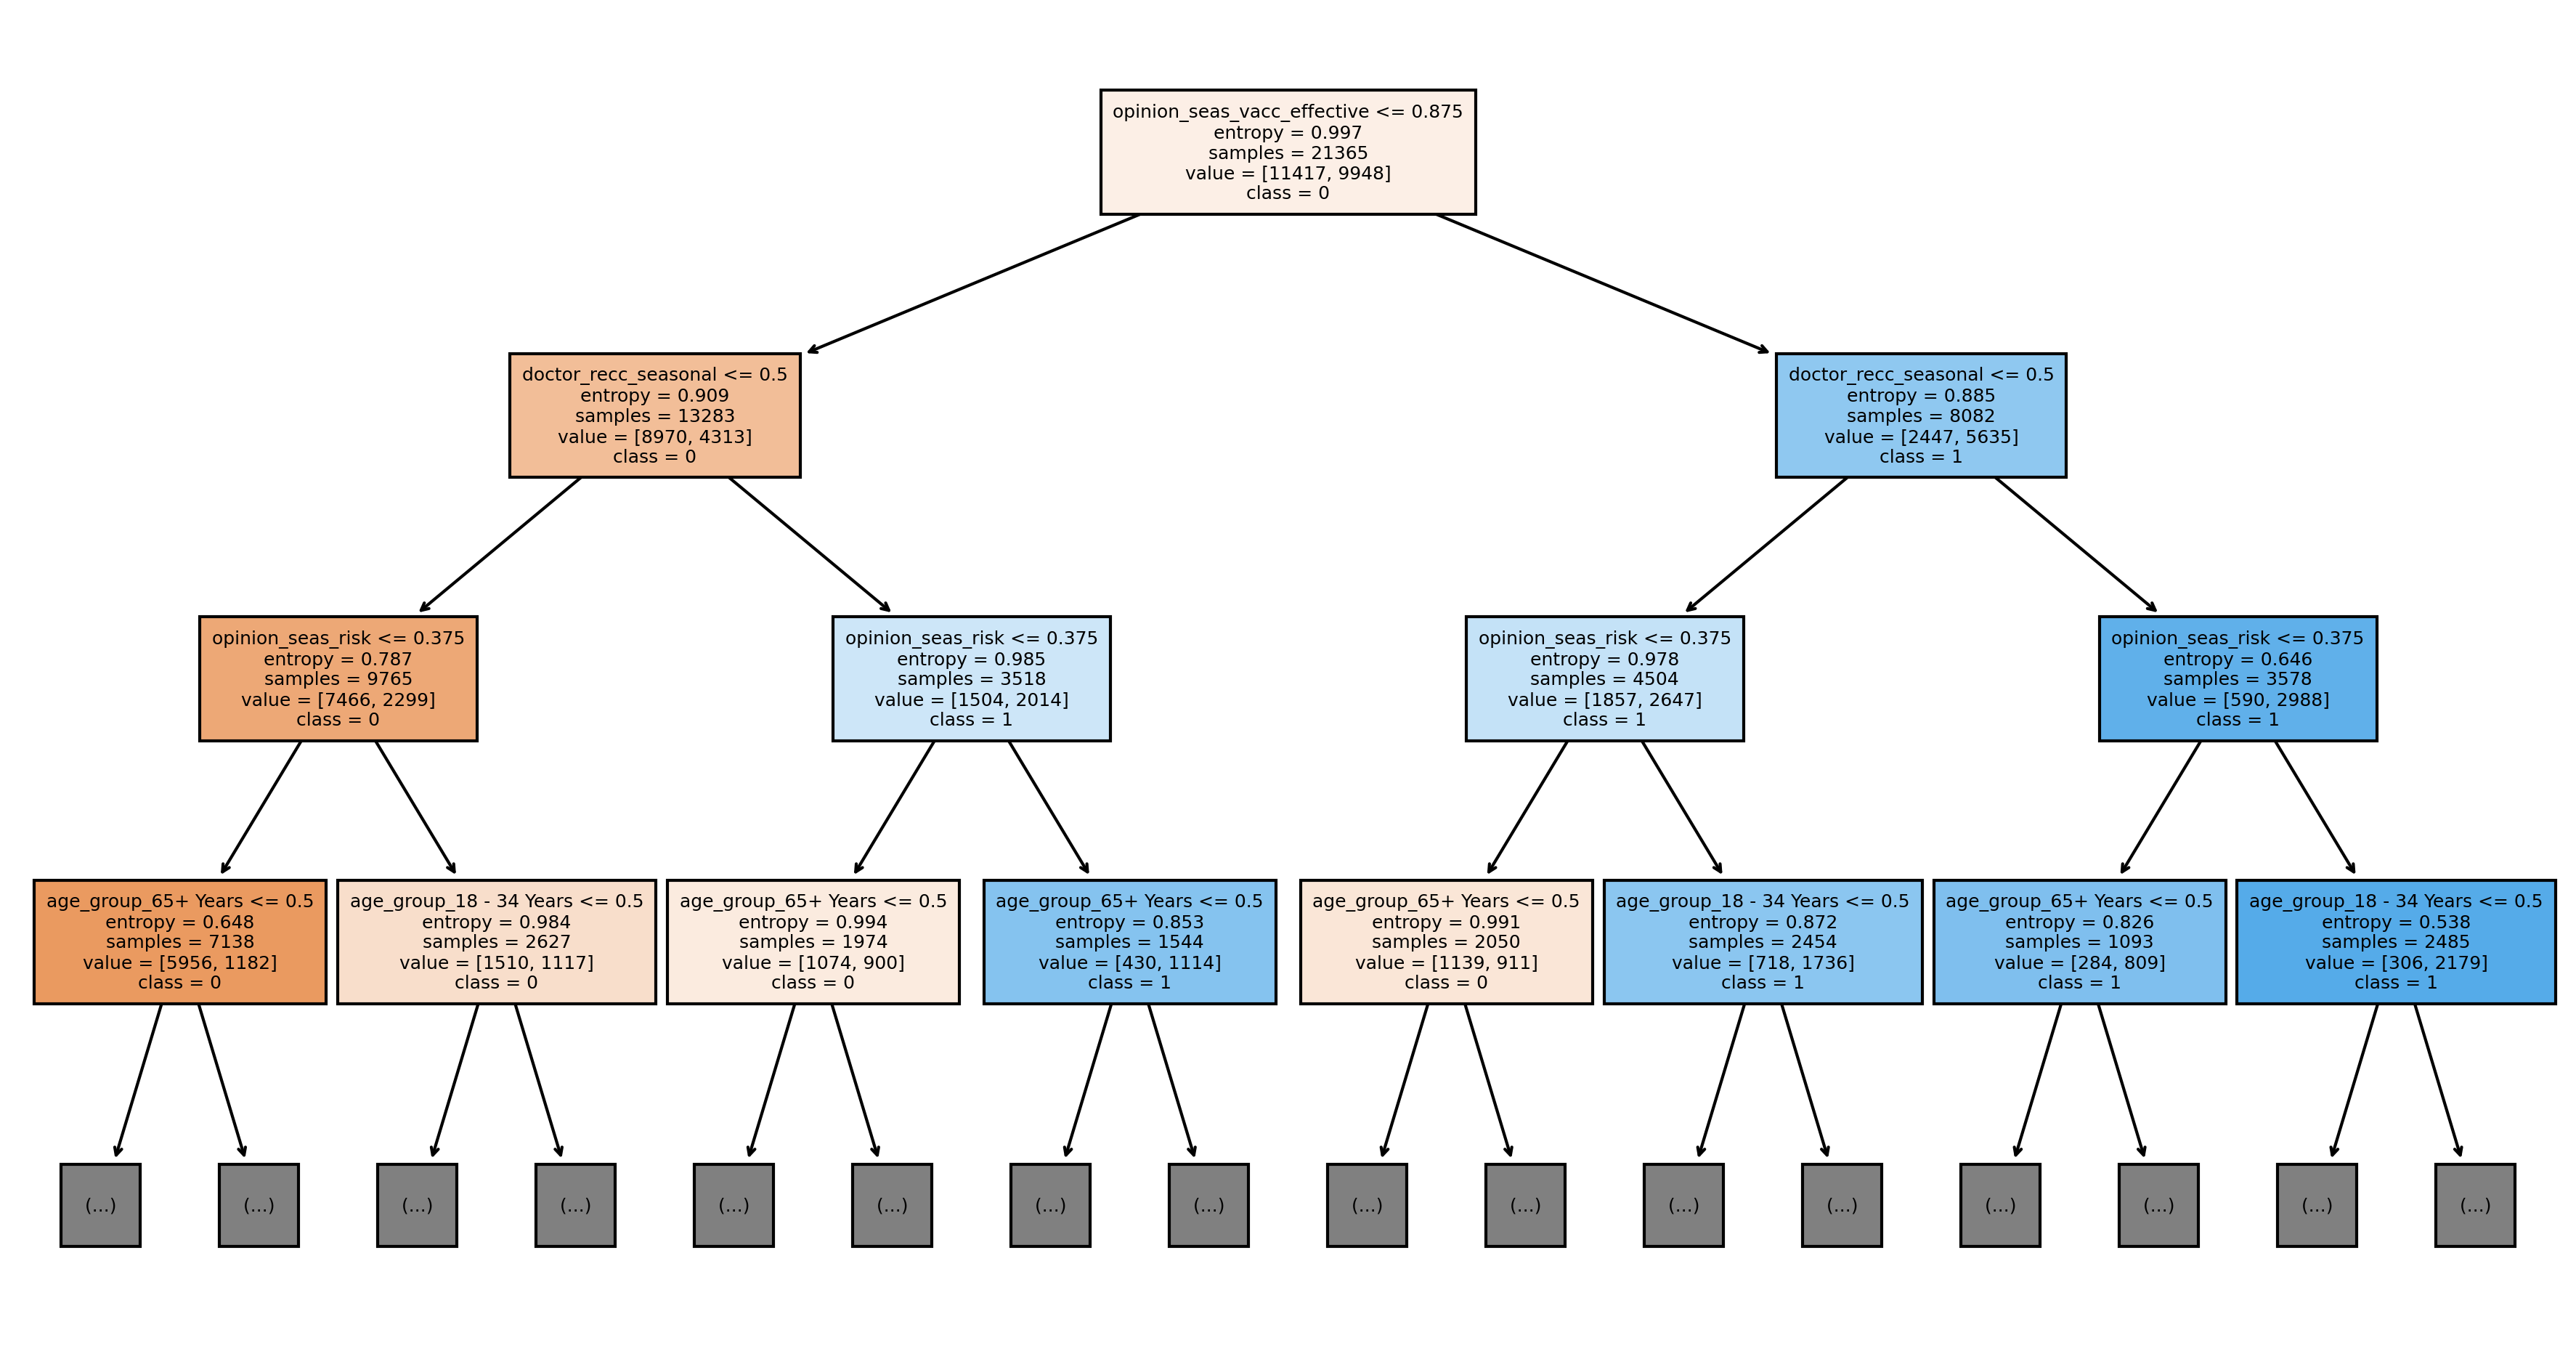

In [13]:
## Create a short tree with the first model to give a sense of scale ## 

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (15,8), dpi=300)
tree.plot_tree(tree_clf,
               feature_names = X_train_scaled.columns, 
               class_names=np.unique(y_train).astype('str'),
               filled = True, 
               max_depth= 3, 
               fontsize = 6)
plt.show()

### Complex Regression Model - Random Forest Tree

In [14]:
## Random Forest Classifer with some changes to the parameters ## 
forest_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= None, random_state= 420)
forest_clf.fit(X_train_scaled,y_train)

## Add into a list for the scores found from the classifer ## 
forest_scores = []
forest_scores.append(forest_clf.score(X_train_scaled, y_train))
forest_scores.append(forest_clf.score(X_test_scaled, y_test))
forest_scores.append(cross_val_score(forest_clf, X_test_scaled, y_test, scoring= 'accuracy').mean())

### Complex Regression Model - Random Forest Tree with Tuning

In [15]:
# param_grid = {
#                 'n_estimators' : [100, 200, 300],
#                 'criterion': ['entropy'],
#                 'max_depth' : [None, 10, 15, 20, 25, 30],
#                 'min_samples_split' : [.1,.2,.3,.4,.5,.6],
#                 'min_samples_leaf' : [.1,.2,.3,.4,.5,.6],
#                 'max_features' : [None, 'sqrt', 10, 15, 20, 25, 30],
#                 'random_state': [420]
#              }

# forest_clf_base = RandomForestClassifier()
# forest_grid_search_v2 = GridSearchCV(forest_clf_base, param_grid, return_train_score= True, cv= 3, scoring= 'accuracy')
# forest_grid_search_v2.fit(X_train_scaled, y_train)

# grid_scores = []
# grid_scores.append(accuracy_score(y_train,forest_grid_search_v2.predict(X_train_scaled)))
# grid_scores.append(accuracy_score(y_test,forest_grid_search_v2.predict(X_test_scaled)))

In [16]:
forest_clf_v2 = RandomForestClassifier(criterion= 'entropy', max_depth= 15, max_features= 15,
                                         min_samples_leaf= 1, min_samples_split= 1, n_estimators= 300, 
                                         random_state= 420)
forest_clf_v2.fit(X_train_scaled, y_train)

grid_scores = []
grid_scores.append(accuracy_score(y_train,forest_clf_v2.predict(X_train_scaled)))
grid_scores.append(accuracy_score(y_test,forest_clf_v2.predict(X_test_scaled)))

## Results

In [17]:
## Loop through the the scores that was collect from the classifiers ## 
for name, score in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning']
                       ,[tree_scores, forest_scores, grid_scores]):
    
    print(f'{name} Model')
    print('Training Accuracy Score: {}%'.format(round(score[0] * 100,2)))
    print('Testing Accuracy Score: {}%'.format(round(score[1] * 100,2)))
    if name in ['Decision Tree', 'Random Forest']:
        print('Cross Validation Score Mean: {}% \n'.format(round(score[2] * 100,2)))

Decision Tree Model
Training Accuracy Score: 100.0%
Testing Accuracy Score: 68.89%
Cross Validation Score Mean: 68.08% 

Random Forest Model
Training Accuracy Score: 83.3%
Testing Accuracy Score: 77.59%
Cross Validation Score Mean: 77.12% 

Random Forest with Tuning Model
Training Accuracy Score: 92.58%
Testing Accuracy Score: 77.97%


In [18]:
## Loop through the scores to get the recall score ## 
for name, clf in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning'],
               [tree_clf, forest_clf, forest_clf_v2]):
    print(name)
    print('Recall Score: {}%'.format(round(recall_score(y_test, clf.predict(X_test_scaled))* 100, 2)))

Decision Tree
Recall Score: 67.59%
Random Forest
Recall Score: 75.67%
Random Forest with Tuning
Recall Score: 75.43%


## Created Functions 

In [19]:
## Function that give the predicted y value based on the list of classifiers and create a combined dataframe ## 

def prediction_df(list_of_clf, X):
    combined_df = pd.DataFrame(columns= ['Tree Pred', 'Forest Pred','Tuned Pred'])
    for num, clf in enumerate(combined_df.columns):
        combined_df[clf] = list_of_clf[num].predict(X)
        
    return combined_df

In [20]:
## Create the confusion matrix with the final tuned model ## 

def display_confusion(classifer, X, true_y):
    y_pred = classifer.predict(X)
    matrix = confusion_matrix(true_y, y_pred)
    disp = ConfusionMatrixDisplay(matrix)
    disp.plot();

## Evaluation

### Decision Tree
The Decision Tree model had a **100%** accuracy when predicting with the training dataset with a **68.21%** accuracy score with the testing dataset. When the accuracies have a large difference, this is a sign of overfitting. This is because decision trees perform a greedy algorithm and will always result in the same model.  

**Solution:** Reduce the max depth or use a model that isn't prone to overfitting. In this case, a **Random Forest** was used for the next model. 

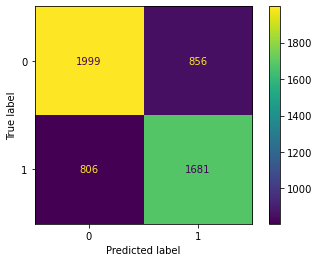

In [21]:
display_confusion(tree_clf, X_test_scaled, y_test)

### Random Forest
The Random Forest was set with a max depth and no restriction to the max amount of features similar to parameters as the decision tree. Random Forest builds upon decision trees made up of an ensemble of trees voting on the results. The Random Forest model had an **83.45%** accuracy on the training dataset and an **77.89%** accuracy score on the testing dataset. Although the training accuracy decreased from the decision tree, the testing accuracy increased instead. This model was not overfitted but the parameters were given to mirror the decision tree default parameters. 

**Solution:** To improve the model, **GridSearch** was used to search through the different hyperparameters to find the best-performing parameters. A directory of parameters was searched to find the best combination of parameters for the random forest model to obtain the best accuracy. 

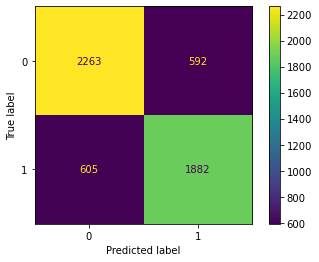

In [22]:
display_confusion(forest_clf, X_test_scaled, y_test)

### Tuned Random Forest
The best parameters from the list, was found with GridSearch with the scoring to the best accuacy. This model has an training accuracy score of **92.59%** and a testing accuracy score of **78.36%**. There was an improvement with the testing accuracy which means that the parameters used was better than the parameters given before. Recall score stayed the say meaning that the model is correctly predicting the number of patient taking the vaccines. 

| Model | Training Accuracy | Testing Accuracy | Recall Score  |                                                                                     
|:------|:-------------:|:------------:|:--:|
| Decison Tree | 100% | 68.21% | 65.33% |
| Random Forest| 83.45%| 77.89% | 75.55% |
| Random Forest with Tuning| 92.59% | 78.36%|75.55%|

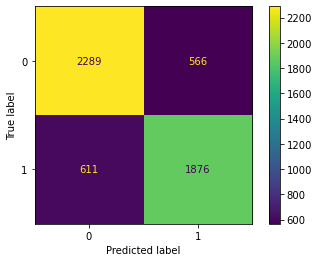

In [23]:
display_confusion(forest_clf_v2, X_test_scaled, y_test)

### Confusion Matrix Analysis
True Positive: **2323** <br>
True Negative: 1863 <br>
False Negative: 553 <br>
False Positive: **603** <br>

For this project, we are more interested on how well the model predict all the true patients that wants the vaccines. **Since extra vaccines are expected**, false positives are benificial to the model and any prediction made with the model. This is why a **higher recall score** is desirable than a higher accuracy score. 

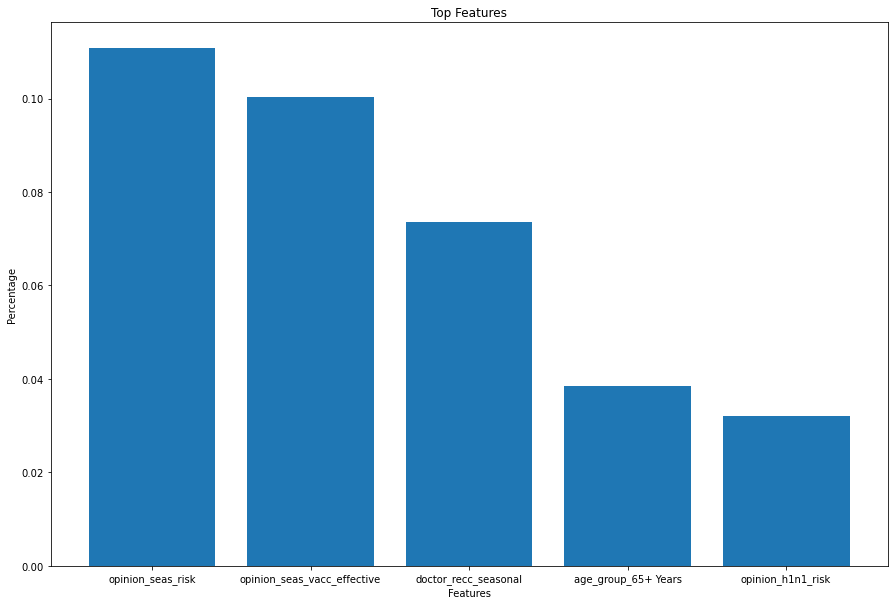

In [24]:
## Sort all the features by their importance ## 

y = forest_clf_v2.feature_importances_
x = forest_clf_v2.feature_names_in_
paired_importance = sorted(zip(x,y), key= lambda x: x[1], reverse= True)

most_important = [name[0] for name in paired_importance[:5]]
important_values = [value[1] for value in paired_importance[:5]]

plt.figure(figsize= (15,10))
plt.title('Top Features')
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.bar(most_important, important_values);

### Top Feature Analysis
The most important features that influence the likihood of taking the seasonal vaccine was their opinion on the vaccine itself. If the patient see a risk in the seasonal flu and know the effectiveness, they were more likely to take it. Age and the doctors recommendation was the other deciding factors until the next one being the risk of H1N1.  

## Example 

In [25]:
## Combine the current value of the test values with the new predicted values
example_df = pd.concat([y_test.reset_index().drop('index', axis = 1), prediction_df([tree_clf, forest_clf, forest_clf_v2], X_test_scaled)], axis = 1)

In [26]:
number = len(example_df)
true_pred = len(example_df.loc[example_df['seasonal_vaccine'] == 1 ])
for clf in example_df.columns[1:]:
    clf_pred = len(example_df[clf].loc[example_df[clf] == 1])
    
    print(clf)
    print("Number of Patients: ", number)
    print("Number of predicted patients taken vaccines: ", clf_pred)
    print("Number of true patients taken vaccines: ", true_pred)
    print("Estimated vaccines needed ", (round(clf_pred * 1.05)))
    print("Wasted Vaccines: ", (round(clf_pred * 1.05) - true_pred))
    print('\n')

Tree Pred
Number of Patients:  5342
Number of predicted patients taken vaccines:  2537
Number of true patients taken vaccines:  2487
Estimated vaccines needed  2664
Wasted Vaccines:  177


Forest Pred
Number of Patients:  5342
Number of predicted patients taken vaccines:  2474
Number of true patients taken vaccines:  2487
Estimated vaccines needed  2598
Wasted Vaccines:  111


Tuned Pred
Number of Patients:  5342
Number of predicted patients taken vaccines:  2442
Number of true patients taken vaccines:  2487
Estimated vaccines needed  2564
Wasted Vaccines:  77




| Classifier | Number of Patients |Prediction| True Prediction | Supply of Vaccine | Wasted Vaccines |                                                                                     
|:----:|:------:|:-------------:|:------------:|:----:|:---:|
|Decision Tree| 5342 | 2455| 2466 | 2577 | 111 | 
|Random Forest| - | 2441| - | 2563 | 97 | 
|Tuned Random Forest | - | **2416**| - | **2537** | **71** | 

## Conclusion
The decision tree classifier performs well on the training dataset but not on the testing dataset. To resolve that, a random forest is used instead to prevent the model from overfitting the dataset when fitted. However, given a large number of combinations of parameters, GridSearch was used to find the best-performing combination for the Random Forest Model. Although the model only had an accuracy of roughly 80%, that will be good enough to allow medical centers to order a reasonable amount of vaccines when the model predicts a respondent's willingness to take the vaccine. With a good enough recall score and extra vaccines, we can minimize the number of vaccines wasted. 

**With 5% extra vaccines supplied, there was only a waste of under 100 vaccines compared to expecting everyone to be taking the vaccines.**

The model should only care about making sure that all the patient that needs a vaccine will receive one as it is better to be prepared than under-prepared. 

## Limitations
Unfortunately, there is a large combination of parameters that the classifier can use to make the best model and it is too computationally complex to look through and compare which has the best performance. That is why only a list of parameters was given to save time and narrow down the best combination. There could be an instance where a specific model performs better with the training set but not the testing set or vice versa. If given time, there could be the best-performing model for a given state but would be unrealistic to obtain a prediction. 
1. Majority of the questions are targeted toward the **H1N1 vaccines** which don't reflect too well if they were to take the **seasonal vaccine**. <br>
The question could become irrelavent if the vaccines aren't needed or in the public mind such as the polio vaccine, which for the most part is elimated. <br>
2. New generations and events may affect **people's willingness** to take the vaccines. <br>
Covid-19 has had an impact on people's perception of vaccines, either good or bad. Along with other factors such as religion, people's opinions will change which can make the model ineffective if not updated for the new population. <br>

## Recommendations
1. Given time, I would recommend exploring **different classification models** and **different combinations** of parameters to improve the model. <br>
Ideally, an 80% would be preferred but not as needed since a medical center should have a range of vaccines supply to take into account situations such as new patients. <br>
2. **Modified or targeted questions** should be added to the survey. <br>
The survey was made asking primarily about the H1N1 virus and could be changed to adapt to the current state of the world such as covid-19. <br>
3. Determine an **adequate amount** of spare vaccines to allocate from one center to another. <br>
Not all medical centers will have the same results and should be treated regionally to maximize the accuracy of the model. For example, I added an extra 5% more vaccines but could be different from city to city. <br>